# ML Starting...

##### El sistema de recomendacion esta hecho para el acompañamiento en la toma de desiciones por parte de inversionistas del la industria gastronomica, en base a: si invertir, o no, en un conjugado de características contenidas en su plan de inversion para el futuro negocio a invertir.

- Ubicacion: (State; City)
- Categoría: (Mexican Food; Fast Food, etc..)
- Atributos:  (Parking; Wheelchair; Petfriendly, etc...) YELP (Disponible) 
- Servcicios: (Parking; Wheelchair; Petfriendly, etc...) gm_misc (Places API... Verificando posibilidad...)
- Cálculo del volumen de estrellas recibido: (eda_yelp_reviews_full)
- Reseñas de los usuarios (Perseption of public resume): - Resumen perspectiva Usuarios
- Horarios de apertura y cierrre (Opcional segun tiempos deadline)
- Descripcion (Opcional NLP; segun tiempos deadline) 

## Importo Solo los datasets necesarios:

#### Para ello se necesitan los datasets:


- Ubicacion y datos generales (eda_yelp_bussines.parquet) - "main"
- Categoría (eda_yelp_bussines.parquet) - "main"
- Atributos = Servcicios (eda_yelp_bussines.parquet) - "main"
- Cálculo del volumen de estrellasrecibido (eda_yelp_reviews_full)
- Reseñas de los usuarios (eda_yelp_reviews_2018_to_2020.parquet + yelp_reviews_2021_to_2022.parquet + yelp_user.parquet ) 
- #Horarios de apertura y cierrre (gmap)
- #Descripcion (gmap)

### Import Libraries:

In [1]:
#!pip install transformer

In [2]:
#!pip install tensorflow

In [3]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

## Estudio datasets:

#### eda_yelp_bussines:

In [4]:
eda_yelp_business = pd.read_parquet('../../../Eda_datasets/eda_yelp_bussines.parquet')

In [5]:
# Eliminar las columnas "latitude" y "longitude"
columnas_a_eliminar = ['latitude', 'longitude','state','address']
eda_yelp_business = eda_yelp_business.drop(columnas_a_eliminar, axis=1)

In [6]:
eda_yelp_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132342 entries, 0 to 132341
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   132342 non-null  object 
 1   name          132342 non-null  object 
 2   city          132342 non-null  object 
 3   stars         132342 non-null  float64
 4   review_count  132342 non-null  int64  
 5   attributes    132342 non-null  object 
 6   categories    132342 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 7.1+ MB


In [7]:
eda_yelp_business.head()

,business_id,name,city,stars,review_count,attributes,categories
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,4.5,13,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food"
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,Ashland City,2.0,6,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea..."
3,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,Brentwood,2.5,13,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sporting Goods, Fashion, Shoe Stores, Shopping..."
4,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,Affton,3.0,19,"{'Caters': 'True', 'Alcohol': ""u'full_bar'"", '...","Pubs, Restaurants, Italian, Bars, American (Tr..."


##### Separar las CATEGORÍAS para conocer su frecuencia: Listado categorias frecuencia:

In [8]:
# Separar las categorías y contar su frecuencia
categories_counts = {}
for categories in eda_yelp_business['categories']:
    categories_list = categories.split(', ')
    for category in categories_list:
        categories_counts[category] = categories_counts.get(category, 0) + 1

# Crear un DataFrame a partir del diccionario de categorías y frecuencias
categories_df = pd.DataFrame(list(categories_counts.items()), columns=['Category', 'Frequency'])

# Ordenar el DataFrame por frecuencia en orden descendente
categories_df = categories_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)


In [9]:
# Mostrar el DataFrame resultante
categories_df.head()

,Category,Frequency
0,Restaurants,51291
1,Food,26714
2,Shopping,22990
3,Beauty & Spas,13614
4,Nightlife,12141


In [10]:
categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298 entries, 0 to 1297
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Category   1298 non-null   object
 1   Frequency  1298 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [11]:
categories_df_top_100 = categories_df.head(100)

In [12]:
categories_df_top_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Category   100 non-null    object
 1   Frequency  100 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


##### Separar las ATTRIBUTES para conocer su frecuencia: Listado attributes frecuencia:

In [13]:

# Crear un diccionario para almacenar la cantidad de valores True para cada clave en attributes
attribute_counts = {}

# Iterar sobre cada entrada en la columna attributes
for attr in eda_yelp_business['attributes']:
    # Convertir la entrada a un diccionario
    attr_dict = eval(attr)  # Se asume que los datos están en formato string de diccionario

    # Iterar sobre cada clave y valor en el diccionario
    for key, value in attr_dict.items():
        # Si el valor es True, incrementar la cuenta para esa clave
        if value == 'True':
            attribute_counts[key] = attribute_counts.get(key, 0) + 1

# Crear un DataFrame a partir del diccionario de counts
attributes_df = pd.DataFrame(list(attribute_counts.items()), columns=['Attribute', 'True_Count'])

# Ordenar el DataFrame por cantidad de True en orden descendente
attributes_df = attributes_df.sort_values(by='True_Count', ascending=False).reset_index(drop=True)


In [14]:

# Mostrar el DataFrame resultante
attributes_df.head()

,Attribute,True_Count
0,BusinessAcceptsCreditCards,110396
1,BikeParking,54612
2,RestaurantsTakeOut,52558
3,GoodForKids,43519
4,RestaurantsGoodForGroups,37953


In [15]:
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Attribute   24 non-null     object
 1   True_Count  24 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 512.0+ bytes


##### Simpli EDA of yelp_business:

<Axes: >

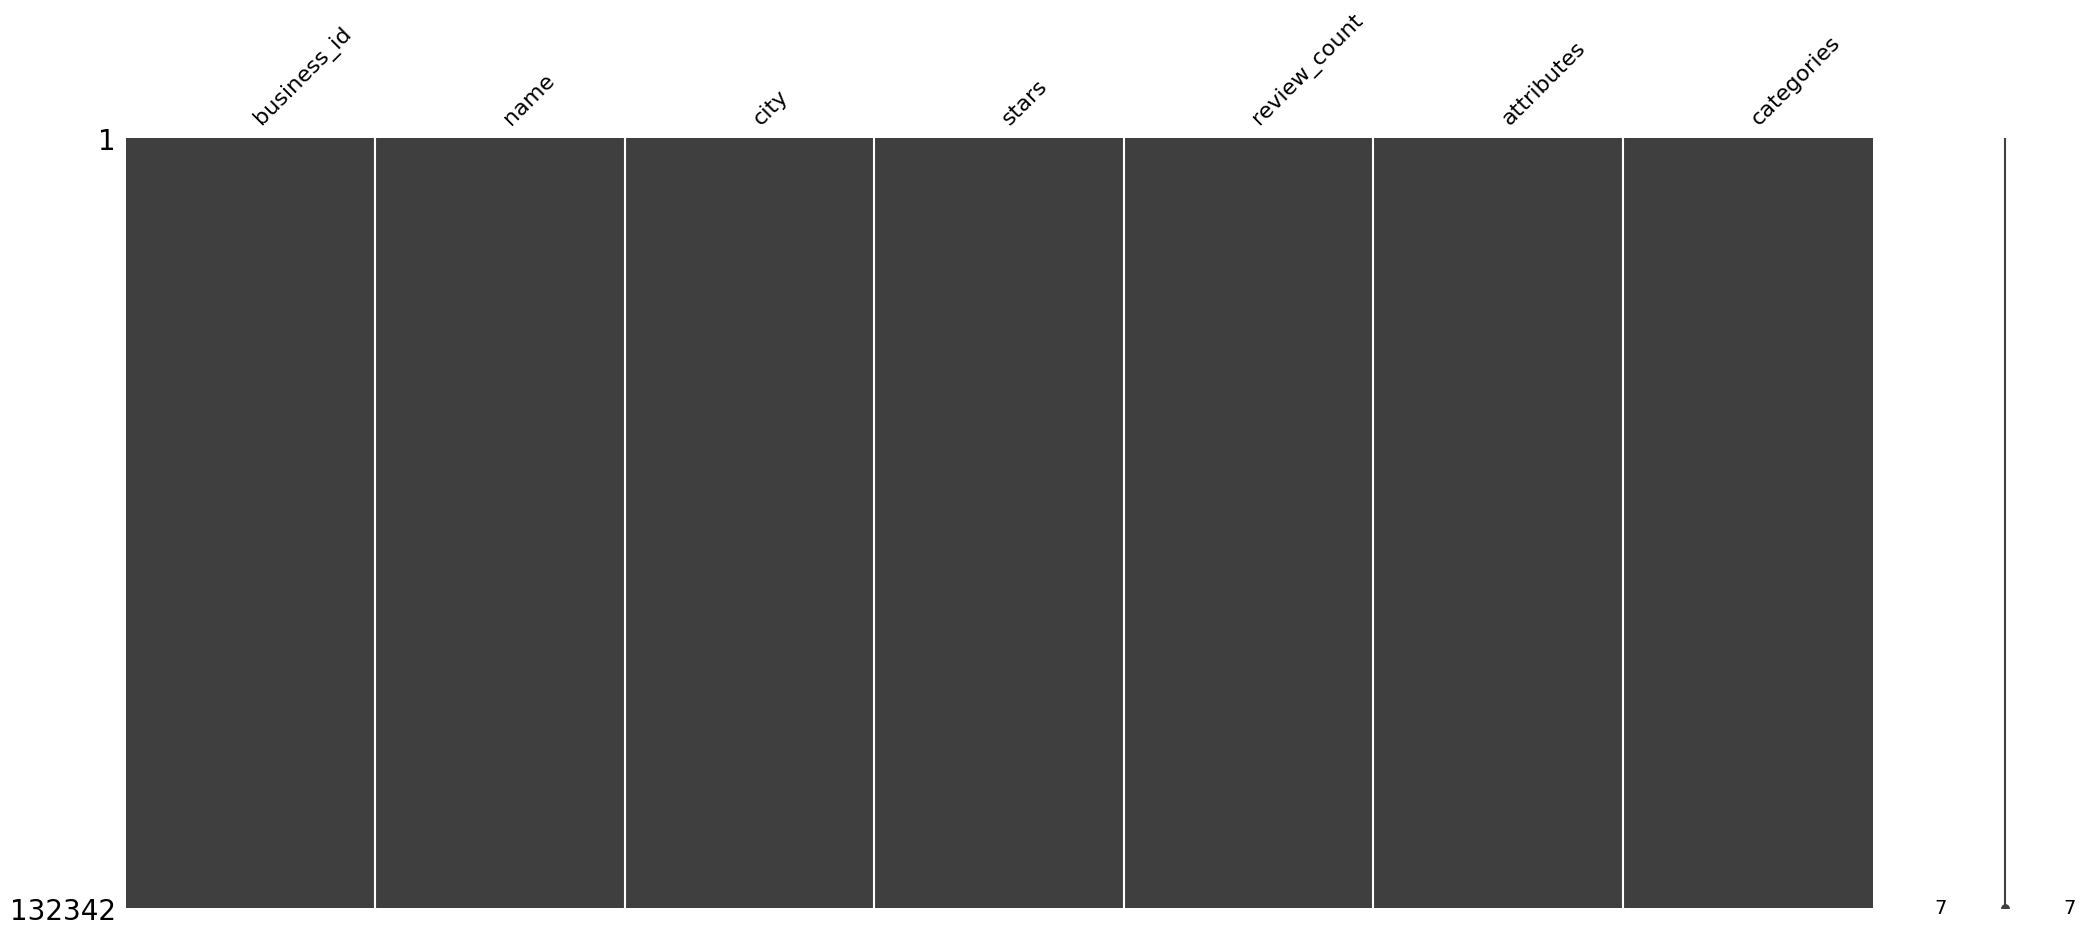

In [16]:
msno.matrix(eda_yelp_business)

### eda_yelp_reviews_2018_to_2020:

In [17]:
eda_yelp_reviews_2018_to_2020 = pd.read_parquet('../../../Eda_datasets/eda_yelp_reviews_2018_to_2020.parquet')

In [18]:
eda_yelp_reviews_2018_to_2020.head(1)

,review_id,user_id,business_id,stars,useful,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,"If you decide to eat here, just be aware it is...",2018-07-07


### eda_yelp_reviews_2021_to_2022:

In [19]:
eda_yelp_reviews_2021_to_2022 = pd.read_parquet('../../../Eda_datasets/eda_yelp_reviews_2021_to_2022.parquet')

In [20]:
eda_yelp_reviews_2021_to_2022.head(1)

,review_id,user_id,business_id,stars,useful,cool,text,date
0,iBUJvIOkToh2ZECVNq5PDg,iAD32p6h32eKDVxsPHSRHA,YB26JvvGS2LgkxEKOObSAw,5,0,0,I've been eating at this restaurant for over 5...,2021-01-08


### Concat eda_yelp_reviews_full:

In [21]:
# Concatenar los DataFrames
eda_yelp_reviews_full = pd.concat([eda_yelp_reviews_2018_to_2020, eda_yelp_reviews_2021_to_2022], ignore_index=True)

In [22]:
# Mostrar el DataFrame concatenado
eda_yelp_reviews_full.head(1)

,review_id,user_id,business_id,stars,useful,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,"If you decide to eat here, just be aware it is...",2018-07-07


### yelp_user:

In [23]:
yelp_user = pd.read_parquet('../../../Eda_datasets/eda_yelp_user.parquet')

In [24]:
yelp_user.head()

,user_id,review_count,yelping_since,useful,cool,fans,average_stars
0,TIvO4GClIYXzxu_jVZ7ruQ,2,2018-01-01,2,0,0,5.00
1,Bxz-sFWLiPx-rR99eBr6TQ,1,2018-01-01,7,1,0,1.00
2,-t7FxAVyh_2XQvi_PvVQkg,1,2018-01-01,0,0,0,2.00
3,9JZLK2tiLUsFLD3wZdUIWQ,3,2018-01-01,2,1,0,1.33
4,J7Y_oLaopwipWnTR8OgVEA,1,2018-01-01,0,0,0,5.00


continuar analizando datasets;
Continuar con renombrar bien las carpetas y suplantar enlaces en el codigo ( quiza pueda quedar asi?)

#### Users estadist - Peso del voto segun usuario:

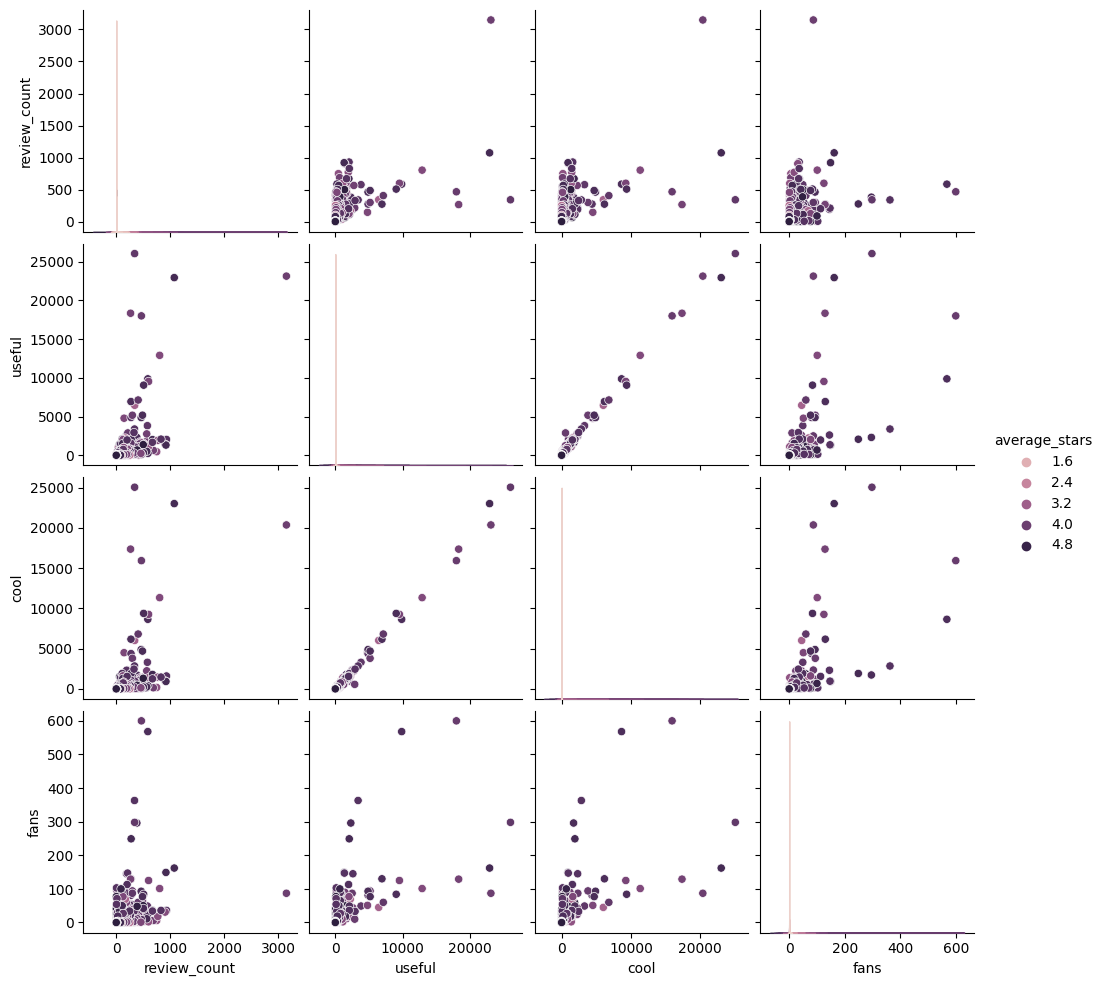

In [25]:
sns.pairplot(yelp_user, hue='average_stars')

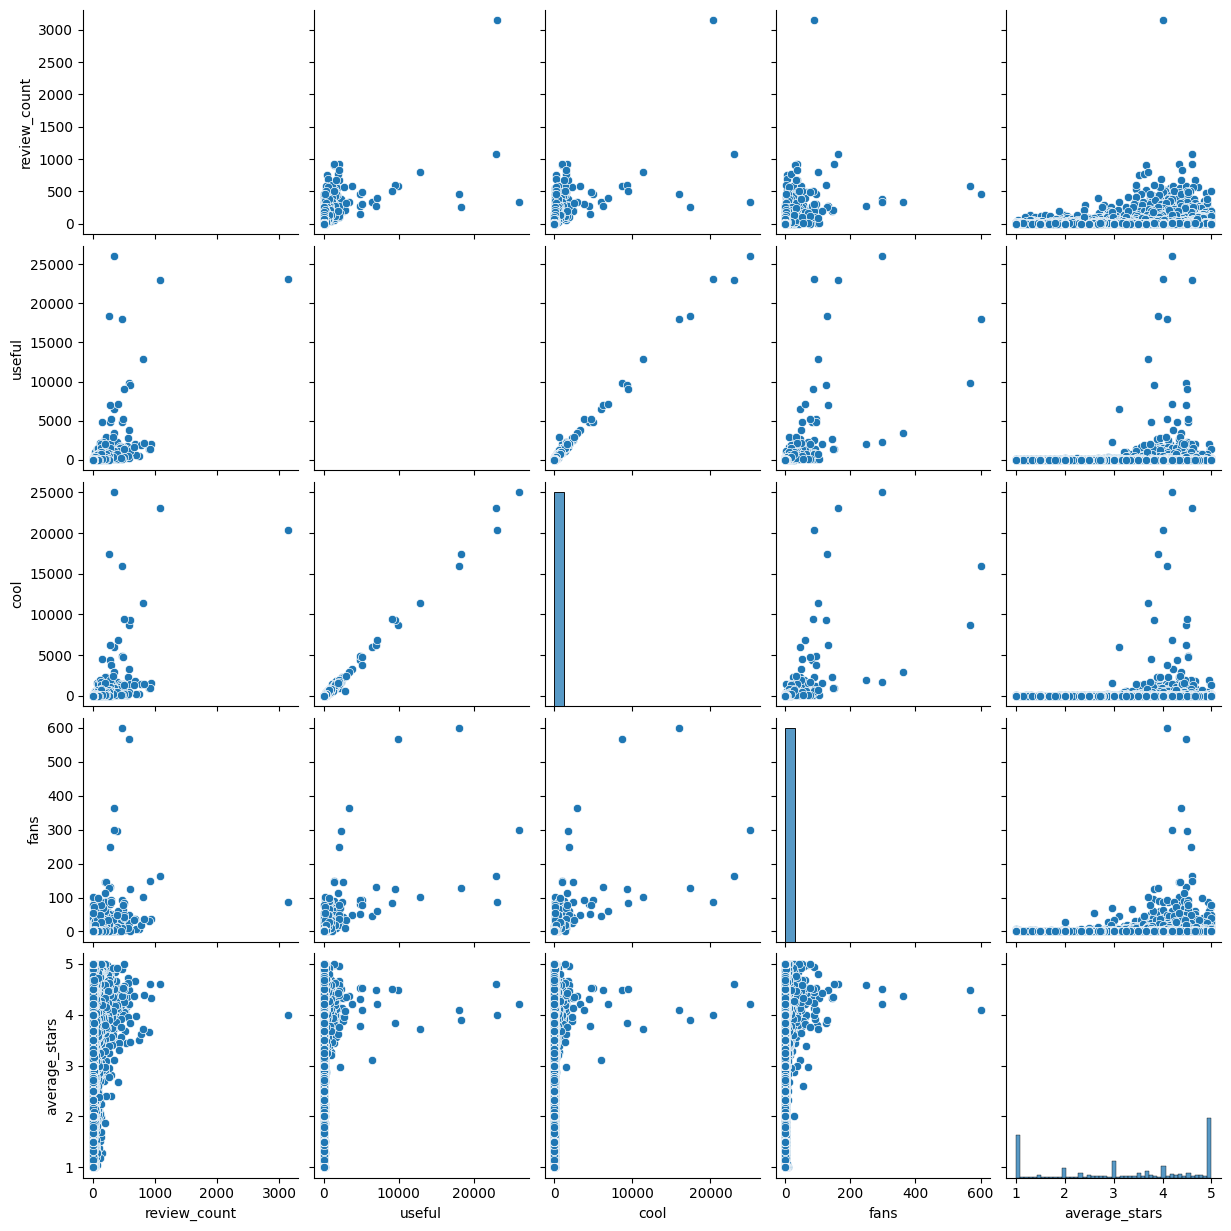

In [26]:
sns.pairplot(yelp_user)

#### Correlation Matrix:

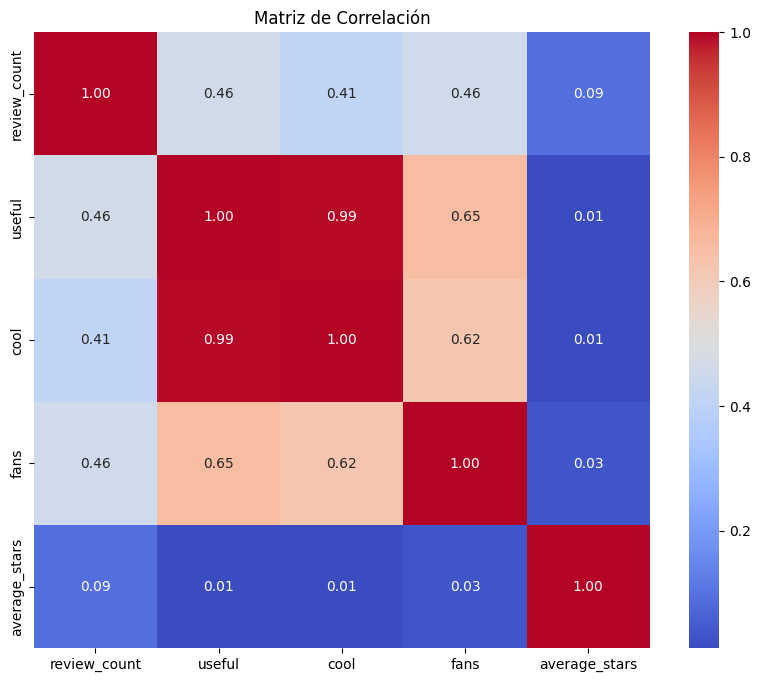

In [27]:

# Calcular la matriz de correlación usando solo las variables numéricas
correlation_matrix = yelp_user[['review_count', 'useful', 'cool', 'fans', 'average_stars']].corr()

# Crear un gráfico heatmap para la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Matriz de Correlación')
plt.show()